In [4]:
!python -V

Python 3.9.19


# Intro

In [5]:
import pandas as pd

In [6]:
import pickle

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [9]:
# reading green tripdata parquet file
df_green = pd.read_parquet('data/green_tripdata_2021-01.parquet')
df_green.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[us]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

In [10]:
# reading green tripdata parquet file
df = pd.read_parquet('data/green_tripdata_2021-01.parquet')

# create new column of duration (in minutes)
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

# filter duration of 1-60 minutes
df = df[(df.duration >= 1) & (df.duration <= 60)]

# feature selection
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [11]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [12]:
# one hot encoding
train_dicts = df[categorical + numerical].to_dict(orient='records')

# dictionary vectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

# select target variable
target = 'duration'
y_train = df[target].values

# train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict
y_pred = lr.predict(X_train)

# evaluate
mean_squared_error(y_train, y_pred, squared=False)

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829628

/tmp/ipykernel_4258/329956811.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_4258/329956811.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


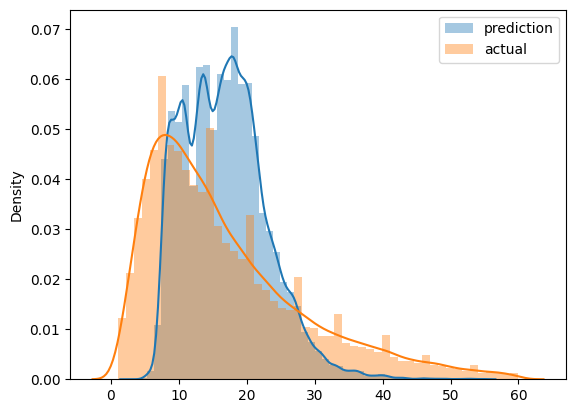

In [13]:
# visualize
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [14]:
# restructure above code into function
# read taxidata function
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [15]:
df_train = read_dataframe('data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('data/green_tripdata_2021-02.parquet')

In [16]:
len(df_train), len(df_val)

(73908, 61921)

In [17]:
# add more features to the model
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [18]:
# model evaluation
categorical = ['PU_DO'] #, 'PULocationID', 'DOLocationID'
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
# model validation
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [24]:
# Import and Setting MLflow
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.sqlite")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716524700327, experiment_id='1', last_update_time=1716524700327, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [25]:
# experiments with linear regression
with mlflow.start_run(run_name='linear-regression'):
    mlflow.set_tag('developer', 'sur')

    mlflow.log_param('train-data-path', 'data/green_tripdata_2021-01.parquet')
    mlflow.log_param('val-data-path', 'data/green_tripdata_2021-02.parquet')

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_metric('rmse', rmse)


    # save model to artifact
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="model")

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
# export model
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [27]:
# experiments with lasso
with mlflow.start_run(run_name='lasso'):
    mlflow.set_tag('developer', 'sur')

    mlflow.log_param('train-data-path', 'data/green_tripdata_2021-01.parquet')
    mlflow.log_param('val-data-path', 'data/green_tripdata_2021-02.parquet')

    alpha = 0.001
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_param('alpha', alpha)
    mlflow.log_metric('rmse', rmse)

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [28]:
# experiments with Ridge
lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.703735100391448

# Adding hyperparameter tuning into notebook using hyperopt

In [29]:
# Import and Setting MLflow
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.sqlite")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716524700327, experiment_id='1', last_update_time=1716524700327, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [30]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [31]:
# set train and validation data for xgboost
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [32]:
# Defining objective function
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [33]:
# Defining search space
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

# Passing information to fmin optimization method
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:26:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.48545                           
[1]	validation-rmse:8.00938                           
[2]	validation-rmse:7.25378                           
[3]	validation-rmse:6.87532                           
[4]	validation-rmse:6.67679                           
[5]	validation-rmse:6.57942                           
[6]	validation-rmse:6.52392                           
[7]	validation-rmse:6.48625                           
[8]	validation-rmse:6.46463                           
[9]	validation-rmse:6.45114                           
[10]	validation-rmse:6.43994                          
[11]	validation-rmse:6.43282                          
[12]	validation-rmse:6.42831                          
[13]	validation-rmse:6.42491                          
[14]	validation-rmse:6.42263                          
[15]	validation-rmse:6.41882                          
[16]	validation-rmse:6.41575                          
[17]	validation-rmse:6.41359                          
[18]	valid

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:27:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.12981                                                     
[1]	validation-rmse:7.66079                                                     
[2]	validation-rmse:7.01291                                                     
[3]	validation-rmse:6.72639                                                     
[4]	validation-rmse:6.59396                                                     
[5]	validation-rmse:6.52802                                                     
[6]	validation-rmse:6.48709                                                     
[7]	validation-rmse:6.46479                                                     
[8]	validation-rmse:6.45163                                                     
[9]	validation-rmse:6.44161                                                     
[10]	validation-rmse:6.43579                                                    
[11]	validation-rmse:6.42973                                                    
[12]	validation-rmse:6.42508

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:27:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.01413                                                    
[1]	validation-rmse:7.55894                                                    
[2]	validation-rmse:6.94929                                                    
[3]	validation-rmse:6.68730                                                    
[4]	validation-rmse:6.56499                                                    
[5]	validation-rmse:6.50734                                                    
[6]	validation-rmse:6.47438                                                    
[7]	validation-rmse:6.45662                                                    
[8]	validation-rmse:6.43711                                                    
[9]	validation-rmse:6.42724                                                    
[10]	validation-rmse:6.41804                                                   
[11]	validation-rmse:6.41377                                                   
[12]	validation-rmse:6.41156            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:28:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.73593                                                   
[1]	validation-rmse:11.29524                                                   
[2]	validation-rmse:10.88915                                                   
[3]	validation-rmse:10.51530                                                   
[4]	validation-rmse:10.17105                                                   
[5]	validation-rmse:9.85477                                                    
[6]	validation-rmse:9.56514                                                    
[7]	validation-rmse:9.29902                                                    
[8]	validation-rmse:9.05632                                                    
[9]	validation-rmse:8.83297                                                    
[10]	validation-rmse:8.63023                                                   
[11]	validation-rmse:8.44548                                                   
[12]	validation-rmse:8.27756            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:30:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.55704                                                    
[1]	validation-rmse:7.26199                                                    
[2]	validation-rmse:6.83179                                                    
[3]	validation-rmse:6.67979                                                    
[4]	validation-rmse:6.60673                                                    
[5]	validation-rmse:6.57129                                                    
[6]	validation-rmse:6.55065                                                    
[7]	validation-rmse:6.53631                                                    
[8]	validation-rmse:6.52133                                                    
[9]	validation-rmse:6.51691                                                    
[10]	validation-rmse:6.51255                                                   
[11]	validation-rmse:6.50839                                                   
[12]	validation-rmse:6.50617            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:30:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.45963                                                    
[1]	validation-rmse:7.99181                                                    
[2]	validation-rmse:7.24738                                                    
[3]	validation-rmse:6.88206                                                    
[4]	validation-rmse:6.69609                                                    
[5]	validation-rmse:6.59752                                                    
[6]	validation-rmse:6.54150                                                    
[7]	validation-rmse:6.50954                                                    
[8]	validation-rmse:6.48737                                                    
[9]	validation-rmse:6.47189                                                    
[10]	validation-rmse:6.46134                                                   
[11]	validation-rmse:6.45547                                                   
[12]	validation-rmse:6.44901            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:31:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.97911                                                    
[1]	validation-rmse:6.68139                                                    
[2]	validation-rmse:6.65261                                                    
[3]	validation-rmse:6.64782                                                    
[4]	validation-rmse:6.64246                                                    
[5]	validation-rmse:6.62888                                                    
[6]	validation-rmse:6.62429                                                    
[7]	validation-rmse:6.61372                                                    
[8]	validation-rmse:6.60695                                                    
[9]	validation-rmse:6.59727                                                    
[10]	validation-rmse:6.59416                                                   
[11]	validation-rmse:6.58779                                                   
[12]	validation-rmse:6.58578            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:31:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.10017                                                    
[1]	validation-rmse:7.70792                                                    
[2]	validation-rmse:7.13107                                                    
[3]	validation-rmse:6.89103                                                    
[4]	validation-rmse:6.78669                                                    
[5]	validation-rmse:6.73503                                                    
[6]	validation-rmse:6.71009                                                    
[7]	validation-rmse:6.69744                                                    
[8]	validation-rmse:6.68485                                                    
[9]	validation-rmse:6.67848                                                    
[10]	validation-rmse:6.67510                                                   
[11]	validation-rmse:6.67210                                                   
[12]	validation-rmse:6.66924            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:32:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.43804                                                    
[1]	validation-rmse:8.00759                                                    
[2]	validation-rmse:7.31060                                                    
[3]	validation-rmse:6.97787                                                    
[4]	validation-rmse:6.81079                                                    
[5]	validation-rmse:6.72412                                                    
[6]	validation-rmse:6.67860                                                    
[7]	validation-rmse:6.64704                                                    
[8]	validation-rmse:6.62633                                                    
[9]	validation-rmse:6.61162                                                    
[10]	validation-rmse:6.59862                                                   
[11]	validation-rmse:6.58955                                                   
[12]	validation-rmse:6.58394            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:33:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.19705                                                   
[1]	validation-rmse:10.34555                                                   
[2]	validation-rmse:9.63645                                                    
[3]	validation-rmse:9.04798                                                    
[4]	validation-rmse:8.56670                                                    
[5]	validation-rmse:8.16823                                                    
[6]	validation-rmse:7.84760                                                    
[7]	validation-rmse:7.58607                                                    
[8]	validation-rmse:7.37366                                                    
[9]	validation-rmse:7.20266                                                    
[10]	validation-rmse:7.06516                                                   
[11]	validation-rmse:6.95234                                                   
[12]	validation-rmse:6.86359            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:35:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.83204                                                     
[1]	validation-rmse:8.42159                                                     
[2]	validation-rmse:7.61864                                                     
[3]	validation-rmse:7.17756                                                     
[4]	validation-rmse:6.93524                                                     
[5]	validation-rmse:6.79784                                                     
[6]	validation-rmse:6.71518                                                     
[7]	validation-rmse:6.66689                                                     
[8]	validation-rmse:6.63416                                                     
[9]	validation-rmse:6.61357                                                     
[10]	validation-rmse:6.59772                                                    
[11]	validation-rmse:6.58759                                                    
[12]	validation-rmse:6.58014

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:36:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.99656                                                     
[1]	validation-rmse:8.60963                                                     
[2]	validation-rmse:7.77108                                                     
[3]	validation-rmse:7.27948                                                     
[4]	validation-rmse:6.99121                                                     
[5]	validation-rmse:6.82346                                                     
[6]	validation-rmse:6.71938                                                     
[7]	validation-rmse:6.65606                                                     
[8]	validation-rmse:6.61457                                                     
[9]	validation-rmse:6.58635                                                     
[10]	validation-rmse:6.56678                                                    
[11]	validation-rmse:6.55231                                                    
[12]	validation-rmse:6.54232

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:37:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.12784                                                     
[1]	validation-rmse:6.71439                                                     
[2]	validation-rmse:6.64632                                                     
[3]	validation-rmse:6.62324                                                     
[4]	validation-rmse:6.61409                                                     
[5]	validation-rmse:6.60598                                                     
[6]	validation-rmse:6.60034                                                     
[7]	validation-rmse:6.59317                                                     
[8]	validation-rmse:6.58899                                                     
[9]	validation-rmse:6.58688                                                     
[10]	validation-rmse:6.57464                                                    
[11]	validation-rmse:6.56932                                                    
[12]	validation-rmse:6.56885

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:37:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.26887                                                     
[1]	validation-rmse:6.75769                                                     
[2]	validation-rmse:6.69139                                                     
[3]	validation-rmse:6.67297                                                     
[4]	validation-rmse:6.66254                                                     
[5]	validation-rmse:6.65821                                                     
[6]	validation-rmse:6.65258                                                     
[7]	validation-rmse:6.64785                                                     
[8]	validation-rmse:6.64322                                                     
[9]	validation-rmse:6.63686                                                     
[10]	validation-rmse:6.63423                                                    
[11]	validation-rmse:6.63156                                                    
[12]	validation-rmse:6.62646

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:38:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.40472                                                     
[1]	validation-rmse:7.97081                                                     
[2]	validation-rmse:7.27917                                                     
[3]	validation-rmse:6.95184                                                     
[4]	validation-rmse:6.78854                                                     
[5]	validation-rmse:6.69639                                                     
[6]	validation-rmse:6.64753                                                     
[7]	validation-rmse:6.62134                                                     
[8]	validation-rmse:6.60423                                                     
[9]	validation-rmse:6.59048                                                     
[10]	validation-rmse:6.58302                                                    
[11]	validation-rmse:6.57720                                                    
[12]	validation-rmse:6.57228

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:38:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.31965                                                     
[2]	validation-rmse:6.95223                                                     
[3]	validation-rmse:6.83567                                                     
[4]	validation-rmse:6.78456                                                     
[5]	validation-rmse:6.76634                                                     
[6]	validation-rmse:6.75166                                                     
[7]	validation-rmse:6.74462                                                     
[8]	validation-rmse:6.73944                                                     
[9]	validation-rmse:6.73603                                                     
[10]	validation-rmse:6.72718                                                    
[11]	validation-rmse:6.72630                                                    
[12]	validation-rmse:6.72248                                                    
[13]	validation-rmse:6.71927

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:39:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.42512                                                     
[1]	validation-rmse:7.93779                                                     
[2]	validation-rmse:7.19511                                                     
[3]	validation-rmse:6.82899                                                     
[4]	validation-rmse:6.64952                                                     
[5]	validation-rmse:6.55477                                                     
[6]	validation-rmse:6.50141                                                     
[7]	validation-rmse:6.46958                                                     
[8]	validation-rmse:6.44856                                                     
[9]	validation-rmse:6.43520                                                     
[10]	validation-rmse:6.42597                                                    
[11]	validation-rmse:6.41971                                                    
[12]	validation-rmse:6.41308

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:40:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.29648                                                    
[1]	validation-rmse:8.99545                                                     
[2]	validation-rmse:8.13755                                                     
[3]	validation-rmse:7.58393                                                     
[4]	validation-rmse:7.22706                                                     
[5]	validation-rmse:6.99809                                                     
[6]	validation-rmse:6.84682                                                     
[7]	validation-rmse:6.74939                                                     
[8]	validation-rmse:6.68504                                                     
[9]	validation-rmse:6.63732                                                     
[10]	validation-rmse:6.60255                                                    
[11]	validation-rmse:6.57989                                                    
[12]	validation-rmse:6.56391

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:41:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.96140                                                     
[1]	validation-rmse:6.88886                                                     
[2]	validation-rmse:6.61966                                                     
[3]	validation-rmse:6.53763                                                     
[4]	validation-rmse:6.50516                                                     
[5]	validation-rmse:6.49092                                                     
[6]	validation-rmse:6.48382                                                     
[7]	validation-rmse:6.47435                                                     
[8]	validation-rmse:6.47056                                                     
[9]	validation-rmse:6.46529                                                     
[10]	validation-rmse:6.45838                                                    
[11]	validation-rmse:6.45184                                                    
[12]	validation-rmse:6.44615

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:42:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.88507                                                    
[1]	validation-rmse:9.84287                                                     
[2]	validation-rmse:9.03508                                                     
[3]	validation-rmse:8.41512                                                     
[4]	validation-rmse:7.94622                                                     
[5]	validation-rmse:7.59125                                                     
[6]	validation-rmse:7.32621                                                     
[7]	validation-rmse:7.12857                                                     
[8]	validation-rmse:6.98093                                                     
[9]	validation-rmse:6.87005                                                     
[10]	validation-rmse:6.78410                                                    
[11]	validation-rmse:6.71847                                                    
[12]	validation-rmse:6.66919

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:43:48] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.17408                                                    
[1]	validation-rmse:10.31498                                                    
[2]	validation-rmse:9.61001                                                     
[3]	validation-rmse:9.03593                                                     
[4]	validation-rmse:8.57133                                                     
[5]	validation-rmse:8.19780                                                     
[6]	validation-rmse:7.89949                                                     
[7]	validation-rmse:7.66057                                                     
[8]	validation-rmse:7.47103                                                     
[9]	validation-rmse:7.31991                                                     
[10]	validation-rmse:7.20014                                                    
[11]	validation-rmse:7.10534                                                    
[12]	validation-rmse:7.03011

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:46:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.51126                                                    
[1]	validation-rmse:10.89033                                                    
[2]	validation-rmse:10.34248                                                    
[3]	validation-rmse:9.85870                                                     
[4]	validation-rmse:9.43282                                                     
[5]	validation-rmse:9.06246                                                     
[6]	validation-rmse:8.73751                                                     
[7]	validation-rmse:8.45550                                                     
[8]	validation-rmse:8.20754                                                     
[9]	validation-rmse:7.99677                                                     
[10]	validation-rmse:7.81021                                                    
[11]	validation-rmse:7.64885                                                    
[12]	validation-rmse:7.51244

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:48:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.46151                                                     
[1]	validation-rmse:9.21474                                                      
[2]	validation-rmse:8.34452                                                      
[3]	validation-rmse:7.74895                                                      
[4]	validation-rmse:7.34532                                                      
[5]	validation-rmse:7.07536                                                      
[6]	validation-rmse:6.89491                                                      
[7]	validation-rmse:6.77124                                                      
[8]	validation-rmse:6.68754                                                      
[9]	validation-rmse:6.62889                                                      
[10]	validation-rmse:6.58427                                                     
[11]	validation-rmse:6.55183                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:50:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.46832                                                    
[1]	validation-rmse:10.81481                                                    
[2]	validation-rmse:10.24174                                                    
[3]	validation-rmse:9.74020                                                     
[4]	validation-rmse:9.30705                                                     
[5]	validation-rmse:8.92604                                                     
[6]	validation-rmse:8.59802                                                     
[7]	validation-rmse:8.31725                                                     
[8]	validation-rmse:8.07630                                                     
[9]	validation-rmse:7.86876                                                     
[10]	validation-rmse:7.68754                                                    
[11]	validation-rmse:7.53477                                                    
[12]	validation-rmse:7.40233

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:52:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.67998                                                     
[1]	validation-rmse:9.54657                                                      
[2]	validation-rmse:8.72104                                                      
[3]	validation-rmse:8.12929                                                      
[4]	validation-rmse:7.71390                                                      
[5]	validation-rmse:7.42156                                                      
[6]	validation-rmse:7.21487                                                      
[7]	validation-rmse:7.07045                                                      
[8]	validation-rmse:6.96690                                                      
[9]	validation-rmse:6.89233                                                      
[10]	validation-rmse:6.83668                                                     
[11]	validation-rmse:6.79793                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:53:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.20620                                                     
[1]	validation-rmse:10.36171                                                     
[2]	validation-rmse:9.65724                                                      
[3]	validation-rmse:9.07362                                                      
[4]	validation-rmse:8.59437                                                      
[5]	validation-rmse:8.20122                                                      
[6]	validation-rmse:7.88123                                                      
[7]	validation-rmse:7.62303                                                      
[8]	validation-rmse:7.41365                                                      
[9]	validation-rmse:7.24396                                                      
[10]	validation-rmse:7.10780                                                     
[11]	validation-rmse:6.99784                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [04:55:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.78982                                                     
[1]	validation-rmse:11.39586                                                     
[2]	validation-rmse:11.02894                                                     
[3]	validation-rmse:10.68853                                                     
[4]	validation-rmse:10.37097                                                     
[5]	validation-rmse:10.07784                                                     
[6]	validation-rmse:9.80322                                                      
[7]	validation-rmse:9.55400                                                      
[8]	validation-rmse:9.32004                                                      
[9]	validation-rmse:9.10363                                                      
[10]	validation-rmse:8.89926                                                     
[11]	validation-rmse:8.71650                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:01:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.62135                                                       
[1]	validation-rmse:11.08517                                                       
[2]	validation-rmse:10.60032                                                       
[3]	validation-rmse:10.16261                                                       
[4]	validation-rmse:9.76860                                                        
[5]	validation-rmse:9.41496                                                        
[6]	validation-rmse:9.09764                                                        
[7]	validation-rmse:8.81322                                                        
[8]	validation-rmse:8.55910                                                        
[9]	validation-rmse:8.33207                                                        
[10]	validation-rmse:8.13049                                                       
[11]	validation-rmse:7.95104                                                

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:04:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.09880                                                       
[1]	validation-rmse:10.18568                                                       
[2]	validation-rmse:9.44232                                                        
[3]	validation-rmse:8.84443                                                        
[4]	validation-rmse:8.36515                                                        
[5]	validation-rmse:7.98364                                                        
[6]	validation-rmse:7.68358                                                        
[7]	validation-rmse:7.44503                                                        
[8]	validation-rmse:7.25697                                                        
[9]	validation-rmse:7.10935                                                        
[10]	validation-rmse:6.99245                                                       
[11]	validation-rmse:6.89897                                                

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:06:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.90362                                                     
[1]	validation-rmse:9.87857                                                      
[2]	validation-rmse:9.08203                                                      
[3]	validation-rmse:8.47997                                                      
[4]	validation-rmse:8.01977                                                      
[5]	validation-rmse:7.67248                                                      
[6]	validation-rmse:7.41444                                                      
[7]	validation-rmse:7.21955                                                      
[8]	validation-rmse:7.07313                                                      
[9]	validation-rmse:6.96153                                                      
[10]	validation-rmse:6.87872                                                     
[11]	validation-rmse:6.81554                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:08:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.22479                                                     
[1]	validation-rmse:8.90471                                                      
[2]	validation-rmse:8.05741                                                      
[3]	validation-rmse:7.52385                                                      
[4]	validation-rmse:7.18793                                                      
[5]	validation-rmse:6.97924                                                      
[6]	validation-rmse:6.84923                                                      
[7]	validation-rmse:6.76264                                                      
[8]	validation-rmse:6.70519                                                      
[9]	validation-rmse:6.66716                                                      
[10]	validation-rmse:6.64113                                                     
[11]	validation-rmse:6.61973                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:09:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.91618                                                     
[1]	validation-rmse:9.90085                                                      
[2]	validation-rmse:9.11469                                                      
[3]	validation-rmse:8.51522                                                      
[4]	validation-rmse:8.06165                                                      
[5]	validation-rmse:7.71458                                                      
[6]	validation-rmse:7.45517                                                      
[7]	validation-rmse:7.26132                                                      
[8]	validation-rmse:7.11517                                                      
[9]	validation-rmse:7.00647                                                      
[10]	validation-rmse:6.92212                                                     
[11]	validation-rmse:6.85969                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:10:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.41845                                                     
[1]	validation-rmse:10.72937                                                     
[2]	validation-rmse:10.13377                                                     
[3]	validation-rmse:9.62248                                                      
[4]	validation-rmse:9.18438                                                      
[5]	validation-rmse:8.80956                                                      
[6]	validation-rmse:8.49220                                                      
[7]	validation-rmse:8.22314                                                      
[8]	validation-rmse:7.99493                                                      
[9]	validation-rmse:7.80300                                                      
[10]	validation-rmse:7.64141                                                     
[11]	validation-rmse:7.50589                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:11:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.26571                                                    
[1]	validation-rmse:8.96511                                                     
[2]	validation-rmse:8.12426                                                     
[3]	validation-rmse:7.58427                                                     
[4]	validation-rmse:7.24735                                                     
[5]	validation-rmse:7.03589                                                     
[6]	validation-rmse:6.90297                                                     
[7]	validation-rmse:6.81440                                                     
[8]	validation-rmse:6.75811                                                     
[9]	validation-rmse:6.71958                                                     
[10]	validation-rmse:6.69482                                                    
[11]	validation-rmse:6.67598                                                    
[12]	validation-rmse:6.66029

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:12:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.65787                                                    
[1]	validation-rmse:11.15340                                                    
[2]	validation-rmse:10.69430                                                    
[3]	validation-rmse:10.27750                                                    
[4]	validation-rmse:9.90027                                                     
[5]	validation-rmse:9.55860                                                     
[6]	validation-rmse:9.25206                                                     
[7]	validation-rmse:8.97607                                                     
[8]	validation-rmse:8.72660                                                     
[9]	validation-rmse:8.50065                                                     
[10]	validation-rmse:8.30281                                                    
[11]	validation-rmse:8.12097                                                    
[12]	validation-rmse:7.96287

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:15:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.72632                                                     
[1]	validation-rmse:9.60815                                                      
[2]	validation-rmse:8.77641                                                      
[3]	validation-rmse:8.16934                                                      
[4]	validation-rmse:7.72895                                                      
[5]	validation-rmse:7.41427                                                      
[6]	validation-rmse:7.18703                                                      
[7]	validation-rmse:7.02568                                                      
[8]	validation-rmse:6.90907                                                      
[9]	validation-rmse:6.82465                                                      
[10]	validation-rmse:6.76145                                                     
[11]	validation-rmse:6.71490                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:16:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.33095                                                    
[1]	validation-rmse:10.57510                                                    
[2]	validation-rmse:9.93306                                                     
[3]	validation-rmse:9.38490                                                     
[4]	validation-rmse:8.92405                                                     
[5]	validation-rmse:8.53801                                                     
[6]	validation-rmse:8.21345                                                     
[7]	validation-rmse:7.94285                                                     
[8]	validation-rmse:7.71625                                                     
[9]	validation-rmse:7.53051                                                     
[10]	validation-rmse:7.37421                                                    
[11]	validation-rmse:7.24352                                                    
[12]	validation-rmse:7.13551

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:18:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.02409                                                    
[1]	validation-rmse:8.63554                                                     
[2]	validation-rmse:7.78317                                                     
[3]	validation-rmse:7.27654                                                     
[4]	validation-rmse:6.97305                                                     
[5]	validation-rmse:6.79239                                                     
[6]	validation-rmse:6.68366                                                     
[7]	validation-rmse:6.61194                                                     
[8]	validation-rmse:6.56525                                                     
[9]	validation-rmse:6.53508                                                     
[10]	validation-rmse:6.51305                                                    
[11]	validation-rmse:6.49603                                                    
[12]	validation-rmse:6.48498

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:19:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.04367                                                    
[1]	validation-rmse:10.10441                                                    
[2]	validation-rmse:9.35393                                                     
[3]	validation-rmse:8.75981                                                     
[4]	validation-rmse:8.29569                                                     
[5]	validation-rmse:7.93348                                                     
[6]	validation-rmse:7.65273                                                     
[7]	validation-rmse:7.43235                                                     
[8]	validation-rmse:7.26483                                                     
[9]	validation-rmse:7.13789                                                     
[10]	validation-rmse:7.03699                                                    
[11]	validation-rmse:6.95600                                                    
[12]	validation-rmse:6.89479

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:20:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.83995                                                     
[1]	validation-rmse:7.42030                                                     
[2]	validation-rmse:6.86564                                                     
[3]	validation-rmse:6.64508                                                     
[4]	validation-rmse:6.54980                                                     
[5]	validation-rmse:6.50696                                                     
[6]	validation-rmse:6.47591                                                     
[7]	validation-rmse:6.46018                                                     
[8]	validation-rmse:6.44825                                                     
[9]	validation-rmse:6.44353                                                     
[10]	validation-rmse:6.43727                                                    
[11]	validation-rmse:6.43366                                                    
[12]	validation-rmse:6.43002

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:20:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.75542                                                     
[1]	validation-rmse:6.81538                                                     
[2]	validation-rmse:6.61628                                                     
[3]	validation-rmse:6.55709                                                     
[4]	validation-rmse:6.53123                                                     
[5]	validation-rmse:6.51496                                                     
[6]	validation-rmse:6.50938                                                     
[7]	validation-rmse:6.49815                                                     
[8]	validation-rmse:6.49211                                                     
[9]	validation-rmse:6.48788                                                     
[10]	validation-rmse:6.48193                                                    
[11]	validation-rmse:6.47187                                                    
[12]	validation-rmse:6.46748

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:21:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80308                                                    
[1]	validation-rmse:11.42066                                                    
[2]	validation-rmse:11.06420                                                    
[3]	validation-rmse:10.73035                                                    
[4]	validation-rmse:10.42116                                                    
[5]	validation-rmse:10.13162                                                    
[6]	validation-rmse:9.86459                                                     
[7]	validation-rmse:9.61539                                                     
[8]	validation-rmse:9.38471                                                     
[9]	validation-rmse:9.17060                                                     
[10]	validation-rmse:8.97289                                                    
[11]	validation-rmse:8.79069                                                    
[12]	validation-rmse:8.62033

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:23:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.57800                                                    
[1]	validation-rmse:9.39677                                                     
[2]	validation-rmse:8.54801                                                     
[3]	validation-rmse:7.95016                                                     
[4]	validation-rmse:7.53190                                                     
[5]	validation-rmse:7.24588                                                     
[6]	validation-rmse:7.05275                                                     
[7]	validation-rmse:6.91300                                                     
[8]	validation-rmse:6.81462                                                     
[9]	validation-rmse:6.74477                                                     
[10]	validation-rmse:6.69106                                                    
[11]	validation-rmse:6.65772                                                    
[12]	validation-rmse:6.62514

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:25:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.71752                                                     
[1]	validation-rmse:6.68266                                                     
[2]	validation-rmse:6.67806                                                     
[3]	validation-rmse:6.66663                                                     
[4]	validation-rmse:6.66033                                                     
[5]	validation-rmse:6.64741                                                     
[6]	validation-rmse:6.64813                                                     
[7]	validation-rmse:6.63865                                                     
[8]	validation-rmse:6.63728                                                     
[9]	validation-rmse:6.63405                                                     
[10]	validation-rmse:6.62945                                                    
[11]	validation-rmse:6.62426                                                    
[12]	validation-rmse:6.62075

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:25:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.74983                                                     
[1]	validation-rmse:8.30459                                                     
[2]	validation-rmse:7.49883                                                     
[3]	validation-rmse:7.05525                                                     
[4]	validation-rmse:6.81502                                                     
[5]	validation-rmse:6.67707                                                     
[6]	validation-rmse:6.59776                                                     
[7]	validation-rmse:6.54724                                                     
[8]	validation-rmse:6.51820                                                     
[9]	validation-rmse:6.49552                                                     
[10]	validation-rmse:6.48129                                                    
[11]	validation-rmse:6.46884                                                    
[12]	validation-rmse:6.46274

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:26:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.60448                                                    
[1]	validation-rmse:11.05634                                                    
[2]	validation-rmse:10.56426                                                    
[3]	validation-rmse:10.12380                                                    
[4]	validation-rmse:9.73130                                                     
[5]	validation-rmse:9.38066                                                     
[6]	validation-rmse:9.06884                                                     
[7]	validation-rmse:8.79265                                                     
[8]	validation-rmse:8.54747                                                     
[9]	validation-rmse:8.33058                                                     
[10]	validation-rmse:8.13901                                                    
[11]	validation-rmse:7.96992                                                    
[12]	validation-rmse:7.82111

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:27:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.36012                                                      
[1]	validation-rmse:10.62744                                                      
[2]	validation-rmse:10.00193                                                      
[3]	validation-rmse:9.46936                                                       
[4]	validation-rmse:9.01845                                                       
[5]	validation-rmse:8.63861                                                       
[6]	validation-rmse:8.31973                                                       
[7]	validation-rmse:8.05303                                                       
[8]	validation-rmse:7.83082                                                       
[9]	validation-rmse:7.64508                                                       
[10]	validation-rmse:7.49057                                                      
[11]	validation-rmse:7.36267                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:28:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.32354                                                      
[1]	validation-rmse:9.03635                                                       
[2]	validation-rmse:8.18049                                                       
[3]	validation-rmse:7.62508                                                       
[4]	validation-rmse:7.27087                                                       
[5]	validation-rmse:7.04389                                                       
[6]	validation-rmse:6.89709                                                       
[7]	validation-rmse:6.80123                                                       
[8]	validation-rmse:6.73723                                                       
[9]	validation-rmse:6.69221                                                       
[10]	validation-rmse:6.66167                                                      
[11]	validation-rmse:6.64129                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:29:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.70822                                                      
[1]	validation-rmse:11.24324                                                      
[2]	validation-rmse:10.81527                                                      
[3]	validation-rmse:10.42363                                                      
[4]	validation-rmse:10.06336                                                      
[5]	validation-rmse:9.73404                                                       
[6]	validation-rmse:9.43320                                                       
[7]	validation-rmse:9.15845                                                       
[8]	validation-rmse:8.90653                                                       
[9]	validation-rmse:8.67718                                                       
[10]	validation-rmse:8.46950                                                      
[11]	validation-rmse:8.28099                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [05:33:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.09303                                                       
[1]	validation-rmse:10.17564                                                       
[2]	validation-rmse:9.43215                                                        
[3]	validation-rmse:8.83227                                                        
[4]	validation-rmse:8.35371                                                        
[5]	validation-rmse:7.97326                                                        
[6]	validation-rmse:7.67313                                                        
[7]	validation-rmse:7.43555                                                        
[8]	validation-rmse:7.24942                                                        
[9]	validation-rmse:7.10339                                                        
[10]	validation-rmse:6.98819                                                       
[11]	validation-rmse:6.89908                                                

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [ ]:
# Running experiments without logging (default is automatically logging)
mlflow.xgboost.autolog(disable=True)

# Training a new model with obtained parameter
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        "learning_rate": 0.16585183602572376,
        "max_depth": 56,
        "min_child_weight": 3.540355118760104,
        "objective": "reg:linear",
        "reg_alpha": 0.34800991293642036,
        "reg_lambda": 0.0037975968660107,
        "seed": 42
    }

    # logging best parameters
    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    # logging preprocessor
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    # logging model
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:29:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.14534
[1]	validation-rmse:10.26384
[2]	validation-rmse:9.53935
[3]	validation-rmse:8.95173
[4]	validation-rmse:8.47317
[5]	validation-rmse:8.09067
[6]	validation-rmse:7.78492
[7]	validation-rmse:7.53894
[8]	validation-rmse:7.34385
[9]	validation-rmse:7.18601
[10]	validation-rmse:7.06155
[11]	validation-rmse:6.96266
[12]	validation-rmse:6.88255
[13]	validation-rmse:6.81814
[14]	validation-rmse:6.76640
[15]	validation-rmse:6.72498
[16]	validation-rmse:6.68869
[17]	validation-rmse:6.65976
[18]	validation-rmse:6.63516
[19]	validation-rmse:6.61415
[20]	validation-rmse:6.59620
[21]	validation-rmse:6.58176
[22]	validation-rmse:6.57002
[23]	validation-rmse:6.56026
[24]	validation-rmse:6.55068
[25]	validation-rmse:6.54248
[26]	validation-rmse:6.53647
[27]	validation-rmse:6.53066
[28]	validation-rmse:6.52633
[29]	validation-rmse:6.52227
[30]	validation-rmse:6.51813
[31]	validation-rmse:6.51454
[32]	validation-rmse:6.51146
[33]	validation-rmse:6.50950
[34]	validation-rmse:6

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:31:36] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


: 

: 

In [ ]:
import mlflow
logged_model = 'runs:/fad2c3332fb64e769797207376f61abc/models_mlflow'

: 

: 

In [ ]:
d

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:43:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: fad2c3332fb64e769797207376f61abc

: 

: 

In [ ]:
# Load model as a XGBoost model.
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:45:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


: 

: 

In [ ]:
# make prediction with xgboost model
y_pred = xgboost_model.predict(valid)
y_pred

array([14.409172 ,  7.172757 , 15.327798 , ..., 13.505672 ,  6.5493946,
        8.113043 ], dtype=float32)

: 

: 